In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from src.envs.amod_env import AMoD
import os
import random
import gymnasium as gym
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import A2C, SAC, PPO

from torch.utils.tensorboard import SummaryWriter
from gymnasium.envs.registration import register
from src.algos.a2c_stable_baselines import CustomMultiInputActorCriticPolicy
from src.algos.sac_stable_baselines import CustomSACPolicy
from src.envs.stable_baselines_env_wrapper import MyDummyVecEnv
from src.misc.utils import FeatureExtractor, RLAlgorithm
from src.algos.stable_baselines_gcn import GCNExtractor
from src.algos.stable_baselines_mpnn import MPNNExtractor
from src.algos.stable_baselines_mlp import MLPExtractor

In [4]:
class EvaluationCallback(BaseCallback):
    def __init__(self, eval_env, tensorboard_writer, eval_freq=1000, save_freq=10000, verbose=1, rl_algorithm=RLAlgorithm.SAC,
                 feature_extractor=FeatureExtractor.GCN):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.tensorboard_writer = tensorboard_writer
        self.eval_freq = eval_freq
        self.save_freq = save_freq
        self.save_path = f"./amod_checkpoints/{rl_algorithm.name}/{feature_extractor.name}/"
    
    def _on_step(self) -> bool:
        if self.num_timesteps % self.eval_freq == 0 or self.num_timesteps == 1:
            validation_reward = self.evaluate_model()
            self.tensorboard_writer.add_scalar("Validation reward", validation_reward, self.num_timesteps)
        if self.num_timesteps % self.save_freq == 0:
            self.save_checkpoint()
        return True
    
    def save_checkpoint(self):
        model_path = os.path.join(self.save_path, f"{self.num_timesteps}_steps.zip")
        self.model.save(model_path)
        print(f"Saving model checkpoint to {model_path}")

    def evaluate_model(self):
        obs = self.eval_env.reset()
        eps_served_demand = 0
        eps_rebalancing_cost = 0
        eps_reward = 0
        done = False
        while not done:
            action, _ = self.model.predict(obs, deterministic=True)
            obs, reward, done, info = self.eval_env.step(action)
            eps_served_demand += float(info[0]["served_demand"])
            eps_rebalancing_cost += float(info[0]["rebalancing_cost"])
            # we read reward from info instead of the returned value so that we can include the reward from
            # the first matching step, which happens in reset()
            eps_reward += float(info[0]["reward"])
        print(f"Reward: {eps_reward:.2f} | ServedDemand: {eps_served_demand:.2f} | Reb. Cost: {eps_rebalancing_cost:.2f}")
        return eps_reward


def run_training(feature_extractor, rl_algorithm):

    random.seed(104)

    # set this to the path to the saved checkpoint (e.g. amod_checkpoints/SAC/GCN/100000_steps.zip) to resume
    # from that checkpoint
    CHECKPOINT_PATH = ""
    device = "cpu"

    run_dir = os.path.join('amod_runs', f'{rl_algorithm.name}/{feature_extractor.name}')
    os.makedirs(run_dir, exist_ok=True)
    writer = SummaryWriter(run_dir)

    # Register the environment
    register(id='CustomEnv-v0', entry_point=AMoD)

    # Create the environment
    env = MyDummyVecEnv([lambda: gym.make('CustomEnv-v0')])

    if feature_extractor == FeatureExtractor.GCN:
        features_extractor_class = GCNExtractor
    elif feature_extractor == FeatureExtractor.MPNN:
        features_extractor_class = MPNNExtractor
    else:
        features_extractor_class = MLPExtractor

    policy_kwargs = dict(
        features_extractor_class=features_extractor_class,
        features_extractor_kwargs={
            "hidden_features_dim": 256, # TODO: make this a cmdline argument
            "num_nodes": env.envs[0].nregion
        }
    )

    if rl_algorithm == RLAlgorithm.A2C:
        model = A2C(CustomMultiInputActorCriticPolicy,
                    env, policy_kwargs=policy_kwargs, verbose=1,
                    use_rms_prop=False, learning_rate=1e-3, ent_coef=0.3, n_steps=100,
                    gamma=0.99, device=device)

        eval_callback = EvaluationCallback(env, writer, eval_freq=1000, save_freq=10000,
                                           rl_algorithm=rl_algorithm, feature_extractor=feature_extractor)
        if CHECKPOINT_PATH and os.path.exists(CHECKPOINT_PATH):
            print("Loading saved model from path ", CHECKPOINT_PATH)
            model = A2C.load(CHECKPOINT_PATH, env=env, device=device)
    elif rl_algorithm == RLAlgorithm.PPO:
        model = PPO(CustomMultiInputActorCriticPolicy, env, policy_kwargs=policy_kwargs,
                    verbose=1, learning_rate=1e-3, ent_coef=0.3, n_steps=100,
                   gamma=0.99, device=device)
        eval_callback = EvaluationCallback(env, writer, eval_freq=1000, save_freq=10000,
                                           rl_algorithm=rl_algorithm, feature_extractor=feature_extractor)
        if CHECKPOINT_PATH and os.path.exists(CHECKPOINT_PATH):
            print("Loading saved model from path ", CHECKPOINT_PATH)
            model = PPO.load(CHECKPOINT_PATH, env=env, device=device)
    else:
        print("Hello #1")
        model = SAC(CustomSACPolicy, env, policy_kwargs=policy_kwargs,
                verbose=1, learning_rate=1e-3, ent_coef=0.3, batch_size=100,
                gamma=0.99, learning_starts=10, device=device, seed=1)
        eval_callback = EvaluationCallback(env, writer, eval_freq=100, save_freq=1000,
                                           rl_algorithm=rl_algorithm, feature_extractor=feature_extractor)
        if CHECKPOINT_PATH and os.path.exists(CHECKPOINT_PATH):
            print("Hello #1")
            print("Loading saved model from path ", CHECKPOINT_PATH)
            model = SAC.load(CHECKPOINT_PATH, env=env, device=device)

    #model.learn(total_timesteps=20000000, callback=eval_callback)
    print(model.device)
    
    model.learn(total_timesteps=400, callback=eval_callback)

    return model

In [5]:
# note that a MPNN won't work here because the amod observation space does not have an edge attr
model = run_training(FeatureExtractor.GCN, RLAlgorithm.SAC)

Running for city  san_francisco
Hello #1
Using cpu device
cpu


c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.nregion to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nregion` for environment variables or `env.get_wrapper_attr('nregion')` that will search the reminding wrappers.
  logger.warn(
c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\utils\passive_env_che

Reward: 13479.50 | ServedDemand: 959.00 | Reb. Cost: 662.40
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 12       |
|    time_elapsed    | 6        |
|    total_timesteps | 81       |
| train/             |          |
|    actor_loss      | -674     |
|    critic_loss     | 5.82e+04 |
|    ent_coef        | 0.3      |
|    learning_rate   | 0.001    |
|    n_updates       | 70       |
---------------------------------
Reward: 14345.00 | ServedDemand: 976.00 | Reb. Cost: 663.00
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 12       |
|    time_elapsed    | 14       |
|    total_timesteps | 180      |
| train/             |          |
|    actor_loss      | -799     |
|    critic_loss     | 5.52e+04 |
|    ent_coef        | 0.3      |
|    learning_rate   | 0.001    |
|    n_updates       | 169      |
------------------------------

In [8]:
env = gym.make('CustomEnv-v0')
state, _ = env.reset()

Running for city  san_francisco


c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\utils\passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
c:\Users\Meshal\miniconda3\envs\RL4AMOD\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [17]:
state['node_features'][:,0:7]

array([[0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37],
       [0.37, 0.37, 0.37, 0.38, 0.38, 0.37, 0.37],
       [0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.39],
       [0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35],
       [0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36],
       [0.28, 0.28, 0.28, 0.29, 0.44, 0.28, 0.28],
       [0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35],
       [0.28, 0.28, 0.28, 0.3 , 0.38, 0.28, 0.28],
       [0.02, 0.02, 0.02, 0.09, 0.09, 0.02, 0.02],
       [0.33, 0.33, 0.33, 0.47, 0.33, 0.33, 0.33]], dtype=float32)

In [26]:
i = 8
for key in sorted(env.unwrapped.dacc[i].keys()):
    print('t:', key, ', dacc', env.unwrapped.dacc[i][key])

t: 1 , dacc 0.0
t: 2 , dacc 0.0
t: 3 , dacc 7.0
t: 4 , dacc 7.0
t: 5 , dacc 0.0
t: 6 , dacc 0.0
t: 9 , dacc 1.0


In [49]:
t=0
i=3

for j in range(10):
     print(env.unwrapped.demand[i,j][t])

0
0
0
0
0
1
0
0
1
0


In [42]:
env.unwrapped.demand

defaultdict(dict,
            {(0, 1): {0: 0,
              1: 0,
              2: 0,
              3: 0,
              4: 0,
              5: 0,
              6: 0,
              7: 0,
              8: 0,
              9: 0,
              10: 0,
              11: 0,
              12: 0,
              13: 0,
              14: 0,
              15: 0,
              16: 0,
              17: 0,
              18: 0,
              19: 0,
              20: 0,
              21: 0,
              22: 0,
              23: 0,
              24: 0,
              25: 0,
              26: 0,
              27: 0,
              28: 0,
              29: 0,
              30: 0,
              31: 0,
              32: 0,
              33: 0,
              34: 0,
              35: 0,
              36: 0,
              37: 0,
              38: 0,
              39: 0},
             (0, 2): {0: 0,
              1: 0,
              2: 0,
              3: 0,
              4: 0,
              5: 0,
              6

In [78]:
env.unwrapped.acc

defaultdict(dict,
            {0: {0: 37, 1: 37},
             1: {0: 37, 1: 37},
             2: {0: 37, 1: 36.0},
             3: {0: 37, 1: 35.0},
             4: {0: 37, 1: 36.0},
             5: {0: 37, 1: 28.0},
             6: {0: 37, 1: 35.0},
             7: {0: 37, 1: 28.0},
             8: {0: 37, 1: 2.0},
             9: {0: 37, 1: 33.0}})

In [ ]:
env.unwrapped.acc

In [79]:
env.unwrapped.dacc

defaultdict(dict,
            {0: defaultdict(float,
                         {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}),
             1: defaultdict(float,
                         {4: 1.0, 3: 1.0, 1: 0.0, 2: 0.0, 5: 0.0, 6: 0.0}),
             2: defaultdict(float,
                         {6: 3.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}),
             3: defaultdict(float,
                         {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}),
             4: defaultdict(float,
                         {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}),
             5: defaultdict(float,
                         {3: 1.0, 4: 16.0, 1: 0.0, 2: 0.0, 5: 0.0, 6: 0.0}),
             6: defaultdict(float,
                         {1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}),
             7: defaultdict(float,
                         {4: 10.0, 3: 2.0, 1: 0.0, 2: 0.0, 5: 0.0, 6: 0.0}),
             8: defaultdict(float,
                         {4: 7.0,
                       

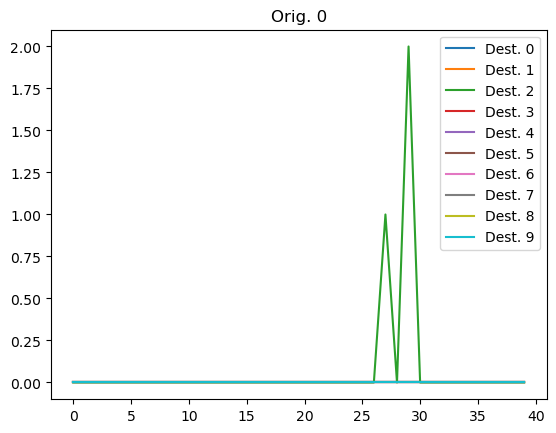

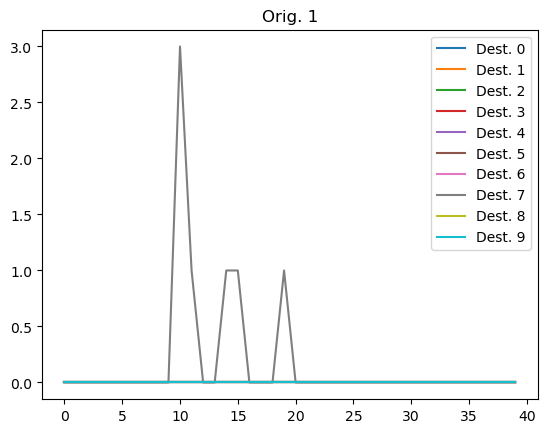

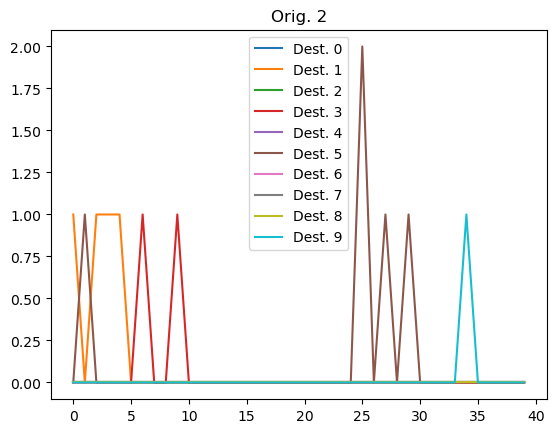

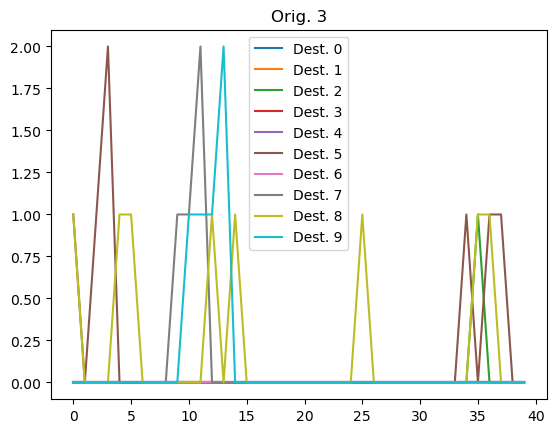

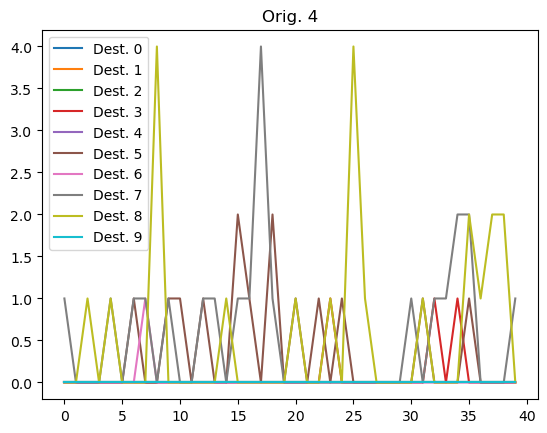

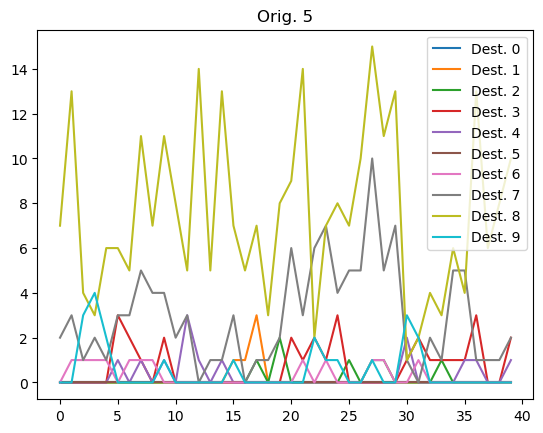

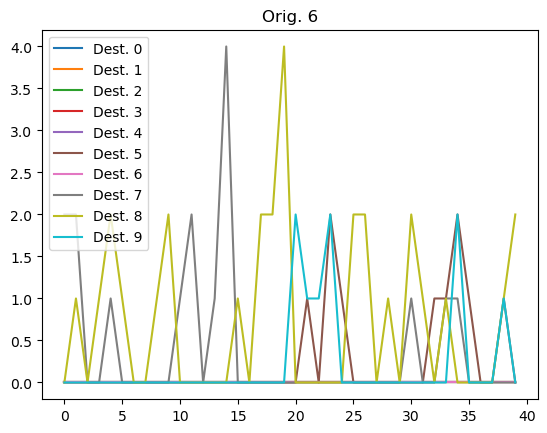

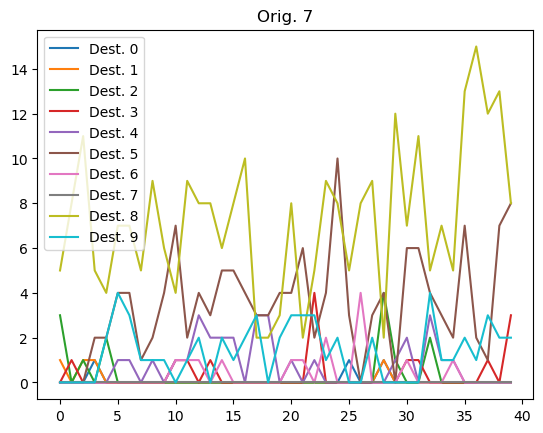

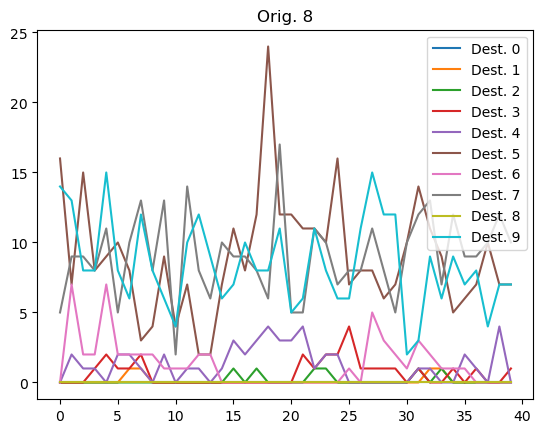

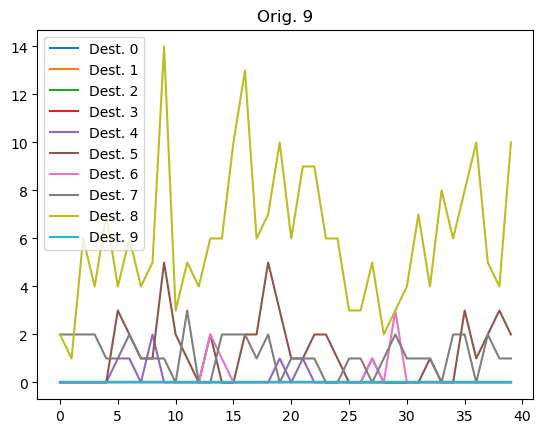

In [76]:
i_list = env.unwrapped.region
j_list = env.unwrapped.region

for i in i_list:

    plt.figure()
    
    for j in j_list:
        time = []
        demand = []
        temp = env.unwrapped.demand[i,j]

        # get key and value from dictionary temp
        for key, value in temp.items():
                time.append(key)
                demand.append(value)

        time = np.array(time)
        demand = np.array(demand)

        plt.plot(time, demand, label = f"Dest. {j}")
        plt.title(f"Orig. {i}")
        plt.legend()


In [72]:
j

0

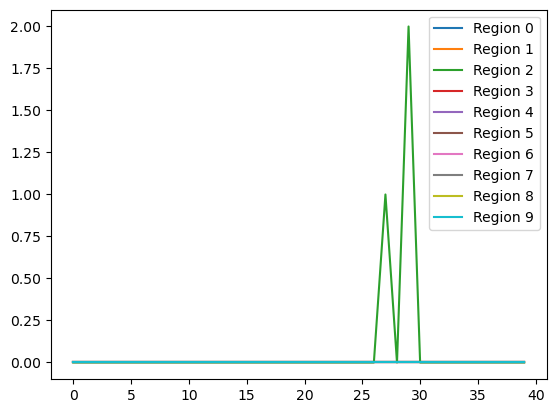

In [68]:
i_list = env.unwrapped.region
j_list = env.unwrapped.region

for i in i_list:

    plt.figure()
    
    for j in j_list:
        print(tripAttr[i,j])

for j in range(10):

    time = []
    demand = []
    temp = env.unwrapped.demand[0,j]

    # get key and value from dictionary temp
    for key, value in temp.items():
            time.append(key)
            demand.append(value)

    time = np.array(time)
    demand = np.array(demand)

    plt.plot(time, demand, label = f"Region {j}")
    plt.legend()

plt.show()

In [69]:
env.unwrapped.region

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [53]:
# get key and value from dictionary temp
for key, value in temp.items():
        time.append(key)
        demand.append(value)

    time = np.array(time)
    demand = np.array(demand)

    plt.plot(time, demand, label = f"Region {j}")

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0}